# Keras RNN Tests
### 2022/07/13, AJ Zerouali
#### Updated: 22/07/19

Loosely follows section 9 of Pierian Data's TF2/Keras Bootcamp. This notebook is to reproduce the lecture code in Keras, but I have a PyTorch implementation that I'm more interested in elsewhere.

## A - RNN on synthetic data

See lectures 80-84. 

### A.0 - Imports
Basic imports:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from datetime import datetime

In [2]:
%matplotlib inline

Data utilities imports:

In [3]:
# MinMax  scaler 
from sklearn.preprocessing import MinMaxScaler

# Batch generator for RNN
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

Neural net layers imports:

In [4]:
# Import Sequential
from keras.models import Sequential

# Import dense, simple RNN and LSTM layers
from keras.layers import Dense, SimpleRNN, LSTM

### **A.1 -The TimeseriesGenerator class**



I'm writing this disgression because I had a very hard time understanding why we're using this class and what it does, especially the arguments used. As it is usually the case with TF2/Keras official documentation, the descriptions are extremely vague, and Portilla doesn't explain the big picture behind his implementation here. I'm using the following reference(s):

* A tutorial on the use of this TimeseriesGenerator: https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/.

* The documentation is at this link:
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/TimeseriesGenerator. To quote their description: This class takes in a sequence of data-points gathered at equal intervals, along with time series parameters such as stride, length of history, etc., to produce batches for training/validation.

For TimeseriesGenerator(), theres is the obvious ***data*** argument, then 3 important ones which are as follows, according to the documentation:

* ***targets***: Targets corresponding to timesteps in data. It should have same length as data.
* ***length***: Length of the output sequences (in number of timesteps).
* ***batch_size***: Number of timeseries samples in each batch (except maybe the last one).

In order to understand how this object is used, let us emphasize the ***importance of the encoding of our data*** prior to feeding it to a neural network.  As previously discussed, a good amount of care has to go into the creation of the input tensors, the number of pixels of images, as well as the dimensions/shapes/formats of the outputs as features are propagated through the layers of the network.

For regular ANNs, the inputs are just vectors. For CNNs, the inputs are obviously batches of images. When dealing with RNNS however, there's an additional component to take into account: ***We are using sequences***, in the sense that our data is ordered in some way: The order of words in the case of NLP, and the time index in the case of time series. Furthermore, when dealing with RNNs, not only are we looking at sequences, but one of the fundamental assumptions is that we are dealing with some type of dynamical system. Note in particular that:

* A first very important point: The idea of using this object is that we're trying to perform a supervised learning task. In this case, we think of time series as inputs and observations of a dynamical system, in the sense that we have input data $\{x_t\}_{t\in I}$ along with output data $\{y_t\}_{t\in I}$. Roughly speaking, we want to learn a *transition function* $f(\cdot,\theta)$, which gives us $y_t = f(x_t,\theta)$ for all $t\in I$.

* A second important point to understand: By predictions given a series of inputs $\{x_1,\cdots,x_k\}$, we mean the actual output $y_1$ (or a set/vector thereof). 

* Note that Keras has a dedicated class for sequential data: the ***tf.keras.utils.Sequence()*** class. The TimeseriesGenerator() is inherited from this Sequence() class. From what I can tell, the main use of this class is to create an iterable that takes into account the time ordering of the data (it's not a Python generator however).

* In the synthetic data example, we want to predict the values $Y_t = x_t$ given the input $X_t = (x_{t-k},\cdots,x_{t-1})$. This is why the *data* and *targets* arguments are the same in the construction of the generator object.

Let's now return to the *length* and *batch_size* arguments. As usual, the ***batch_size*** argument is the *number of samples in one batch*. The confusion with time series is then how you define a sample.Obviously it's going to be a subset of consecutive values of the original time series. This brings us to the ***length*** of each of these samples, which we can define as the number of lag observations $k$ in the input $(x_t,\cdots, x_{t+k})$ of each sample.



**Example 1**:

Here is a first example where we will take the data and targets to be the same in the TimeseriesGenerator(). First we generate the values of $x^2$ on $[0,50]$ with 501 values.

In [5]:
a = np.linspace(start=0, stop = 50, num=501)

In [88]:
f_a =  (a**2)

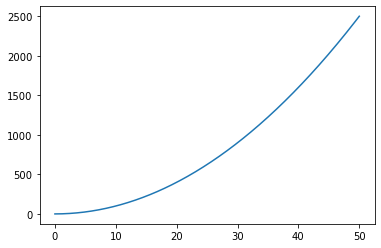

In [89]:
plt.plot(a,f_a)

In [90]:
# The data
fa_data = np.array([a,f_a])

In [91]:
fa_data.shape

(2, 501)

Now we create a first generator with:

            length = 50
            batch_size = 1

In [111]:
# Generator parameters:
xlen_0 = 50
batch_size_0 = 1
generator_0 = TimeseriesGenerator(data = f_a, targets = f_a, length = ylen_0, batch_size = batch_size_0)

Now take 2 batches, according to the index of the generator:

In [93]:
X_0,y_0 = generator_0[0]

In [94]:
X_5, y_5 = generator_0[5]

Notice the shapes:

In [95]:
X_0.shape

(1, 50)

In [96]:
y_0.shape

(1,)

For the batch of index i=0, note that:

            X_0 = f_a[:50]
            y_0 = f_a[50]

In [97]:
X_0[0]

array([0.000e+00, 1.000e-02, 4.000e-02, 9.000e-02, 1.600e-01, 2.500e-01,
       3.600e-01, 4.900e-01, 6.400e-01, 8.100e-01, 1.000e+00, 1.210e+00,
       1.440e+00, 1.690e+00, 1.960e+00, 2.250e+00, 2.560e+00, 2.890e+00,
       3.240e+00, 3.610e+00, 4.000e+00, 4.410e+00, 4.840e+00, 5.290e+00,
       5.760e+00, 6.250e+00, 6.760e+00, 7.290e+00, 7.840e+00, 8.410e+00,
       9.000e+00, 9.610e+00, 1.024e+01, 1.089e+01, 1.156e+01, 1.225e+01,
       1.296e+01, 1.369e+01, 1.444e+01, 1.521e+01, 1.600e+01, 1.681e+01,
       1.764e+01, 1.849e+01, 1.936e+01, 2.025e+01, 2.116e+01, 2.209e+01,
       2.304e+01, 2.401e+01])

In [98]:
y_0

array([25.])

In [99]:
np.equal(f_a[0:50], X_0)

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True]])

In [100]:
np.equal(y_0,f_a[50])

array([ True])

Now we look at the second batch with index i = 5, for which:
            
            X_5 = f_a[5:5+50]
            y_5 = f_a[5+50]

In [110]:
print(f"np.equal(f_a[5:55],X_5)={np.equal(f_a[5:55],X_5)}")
print(f"np.equal(f_a[55],y_5)={np.equal(f_a[55],y_5)}")

np.equal(f_a[5:55],X_5)=[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True]]
np.equal(f_a[55],y_5)=[ True]


Indeed:

In [101]:
i=5

In [102]:
X_5

array([[ 0.25,  0.36,  0.49,  0.64,  0.81,  1.  ,  1.21,  1.44,  1.69,
         1.96,  2.25,  2.56,  2.89,  3.24,  3.61,  4.  ,  4.41,  4.84,
         5.29,  5.76,  6.25,  6.76,  7.29,  7.84,  8.41,  9.  ,  9.61,
        10.24, 10.89, 11.56, 12.25, 12.96, 13.69, 14.44, 15.21, 16.  ,
        16.81, 17.64, 18.49, 19.36, 20.25, 21.16, 22.09, 23.04, 24.01,
        25.  , 26.01, 27.04, 28.09, 29.16]])

In [103]:
y_5

array([30.25])

In [112]:
f_a[i:i+xlen_0]

array([ 0.25,  0.36,  0.49,  0.64,  0.81,  1.  ,  1.21,  1.44,  1.69,
        1.96,  2.25,  2.56,  2.89,  3.24,  3.61,  4.  ,  4.41,  4.84,
        5.29,  5.76,  6.25,  6.76,  7.29,  7.84,  8.41,  9.  ,  9.61,
       10.24, 10.89, 11.56, 12.25, 12.96, 13.69, 14.44, 15.21, 16.  ,
       16.81, 17.64, 18.49, 19.36, 20.25, 21.16, 22.09, 23.04, 24.01,
       25.  , 26.01, 27.04, 28.09, 29.16])

In [113]:
f_a[i+xlen_0]

30.25

Finally, note the length of the generator:

In [115]:
len(generator_0)

451

In symbols, we have:        

            f_a[i:i+xlen_0] = generator_0[i][0],
            f_a[i+xlen_0] = generator_0[i][0].     
Letting $\left(f_a[i])\right)_{i=0,\cdots ,N}$ denote our data vector *f_a*, starting from the index $T$ = *ylen_0* of the data (here $T=50$, $N=501$), the call:

        generator_0 = TimeseriesGenerator(f_a,f_a, length = 50, batch_size = 1)

takes all the values $(f_a[T+1],\cdots,f_a[N])$ as ***output values of the 50 previous lags, for each point*** $f_a[i]$ with $i=T,\cdots,N$, where the ***input*** for $y_i = f_a[i]$ is $(x_{i-T},\cdots,x_{i-1})=f_a[i-T,\cdots,i-1]$. Now note that here, we have $(N-T)$ batches in total, since we set each sample to be a an entire batch.

Suppose we now take 10 samples in each batch, and make a new time series generator, *generator_1*. The iterator *generator_1* is essentially the set of batches, in the sense that the *i*-th batch is *generator_1[i]* (I think it's simply a set of pointers, and when you call the object it returns the corresponding values in memory).
            

In [150]:
# A second generator
xlen_1 = 50 # Length of output sequences
batch_size_1 = 10
generator_1 = TimeseriesGenerator(data = f_a, targets = f_a, length = xlen_1, batch_size = batch_size_1)

Since we look *batch_size*=10, we expect 451/10 ~= 46 batches:

In [151]:
len(generator_1)

46

To understand how our values $\{f_a[i]\}$ are organized in this case, let's look at the 5th batch in our generator:

In [161]:
m=10
i=5
X,y = generator_1[i-1]

Let $T=50$ and $N=451$ as before, and let $m=10$ be our batch size. For i=5, the $y$ values of this batch should be $(y_{40},\cdots,y_{49})$ (last index is $(i\cdot m-1)$), which correspond to $(f_a[40+T],\cdots, f_a[49+T])$:

In [165]:
# np.equal(y,f_a[90:99])
np.equal(y,f_a[(i-1)*m+xlen_1:i*m+xlen_1])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

Now let's look at the second (j=2) value of this batch, namely $y_{41}=f_a[91]$. The corresponding sequence of $x$ values is $(f_a[41],\cdots, f_a[90])$

In [173]:
j=2
np.equal(X[1], f_a[41:91])


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

Lastly, note that in the 46-th batch, we only have one value of $y$:

In [174]:
generator_1[46-1]

(array([[2025.  , 2034.01, 2043.04, 2052.09, 2061.16, 2070.25, 2079.36,
         2088.49, 2097.64, 2106.81, 2116.  , 2125.21, 2134.44, 2143.69,
         2152.96, 2162.25, 2171.56, 2180.89, 2190.24, 2199.61, 2209.  ,
         2218.41, 2227.84, 2237.29, 2246.76, 2256.25, 2265.76, 2275.29,
         2284.84, 2294.41, 2304.  , 2313.61, 2323.24, 2332.89, 2342.56,
         2352.25, 2361.96, 2371.69, 2381.44, 2391.21, 2401.  , 2410.81,
         2420.64, 2430.49, 2440.36, 2450.25, 2460.16, 2470.09, 2480.04,
         2490.01]]),
 array([2500.]))

**Summary**:

To summarize, the purpose of the *TimeseriesGenerator()* class is to create an iterable sequence, where each element is a batch. Since we are considering state-space models of time series, we want our batches to be of the form $\{(x^{(1)}_i,\cdots,x^{(T)}_i,y_i)\}_{i=1}^{n_{\text{batches}}}$. When calling this class, the *data* argument corresponds to the time series of inputs $\{x_t\}=\{x^(t')_i\}$, the *targets* argument corresponds to the outputs $\{y_t\}$. The *batch_size* argument corresponds to the number of values of $y_t$ in each batch, and finally, the *length* argument corresponds to the number of lags of $x$'s that $y_t$ is a function of.

Given these arguments, the generator then organizes the $y_t$'s in "chronological" order in each batch (as many as *batch_size*), and for each output value, takes the corresponding number *length* of values of $x_t$. When training an RNN with the Sequential.fit() method in Keras, one then passes this generator as the data argument, which avoids writing a routine to organize the batches and the input/output arrays.

### A.2 - Synthetic Data

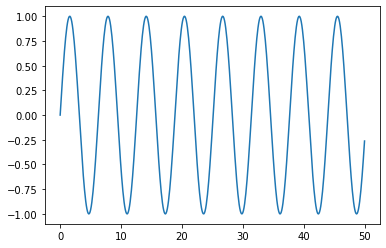

In [6]:
 # Generate synthetic data
t = np.linspace(start=0, stop=50, num=501)
X_t = np.sin(t)
plt.plot(t,X_t)

In [7]:
# DataFrame
df_X = pd.DataFrame(data =X_t, index= t , columns = ['Sine'])

# Test percentage and index
test_data_percentage = 0.1
test_data_idx = len(df_X)-int(len(df_X)*test_data_percentage)

# Train-test split
df_X_train = df_X.iloc[:test_data_idx]
df_X_test = df_X.iloc[test_data_idx:]

In [8]:
df_X_train

,Sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418
...,...
44.6,0.579164
44.7,0.657656
44.8,0.729577
44.9,0.794208


Some data pre-processing now. Instantiate and fit a MinMaxScaler:

In [9]:
# Inst. scaler
data_scaler = MinMaxScaler()

# Fit to training data
data_scaler.fit(df_X_train)

MinMaxScaler()

Transforming the data now, note that we're obtaining np arrays instead of DataFrames:

In [10]:
# Scale training and test sets
X_train_ = data_scaler.transform(df_X_train)
X_test_ = data_scaler.transform(df_X_test)

In [11]:
X_train_.shape

(451, 1)

In [12]:
X_test_.shape

(50, 1)

### Time series generator

We want our model to learn a transition function $f(\cdot\ ;\theta)$ such that:

$$ x_{(t+T)} = y_t = f(x_t,\cdots,x_{t+T-1};\theta).$$

We will instantiate a generator that will produce $x_t$ values as outputs of the time series itself. In particular, we will take batches of size 1, and 50 lags of the time series, i.e. $T=50$ in the equation above.



In [13]:
# Generator parameters:
n_x_lags = 50
y_batch_size = 1

In [14]:
TSGen = TimeseriesGenerator(data = X_train_, targets = X_train_, length = n_x_lags, batch_size = y_batch_size)

In [19]:
help(TimeseriesGenerator)

Help on class TimeseriesGenerator in module keras.preprocessing.sequence:

class TimeseriesGenerator(keras_preprocessing.sequence.TimeseriesGenerator, keras.utils.data_utils.Sequence)
 |  TimeseriesGenerator(data, targets, length, sampling_rate=1, stride=1, start_index=0, end_index=None, shuffle=False, reverse=False, batch_size=128)
 |  
 |  Utility class for generating batches of temporal data.
 |  
 |  This class takes in a sequence of data-points gathered at
 |  equal intervals, along with time series parameters such as
 |  stride, length of history, etc., to produce batches for
 |  training/validation.
 |  # Arguments
 |      data: Indexable generator (such as list or Numpy array)
 |          containing consecutive data points (timesteps).
 |          The data should be at 2D, and axis 0 is expected
 |          to be the time dimension.
 |      targets: Targets corresponding to timesteps in `data`.
 |          It should have same length as `data`.
 |      length: Length of the outp

Since we took 451 points to be inputs $x_t$ in our training data, taking $T=50$ lags will give us 401 output samples  $y_t$:

In [15]:
len(TSGen)

401

In [16]:
len(X_train_)

451

As explained in the previous section, the generator simply reorganizes our data:

In [17]:
X,y = TSGen[0]

In [18]:
print(f"np.equal(y,X_train_[50])={np.equal(y[0],X_train_[50])}")
print(f"np.array_equal(X[0],X_train_[0:50])={np.array_equal(X[0],X_train_[0:50])}")

np.equal(y,X_train_[50])=[ True]
np.array_equal(X[0],X_train_[0:50])=True


### A.3 - Model construction

As we would expect, the crucial object in our model is the (simple) RNN unit, implemented in Keras as *SimpleRNN()*.
Links to docs:

* TF2 docs on *SimpleRNN()*: https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN.
* Keras - Working with RNNs: https://keras.io/guides/working_with_rnns/.

The arguments we need to specify for our RNN unit are:

* ***units***: Number of neurons in the RNN unit, here we'll take 2x*n_x_lags*.
* ***input_shape***: Will be (*n_x_lags*, *n_features*), where *n_features* is the number of features used to predict the output. Since we're predicting $y$ from only one "feature" $x$, we take *n_features*=1.

**Comments/Questions:** 
1) The *input_shape* is not in the docs. Way to go Google Brain.
2) There's a confusing point here: Keras' docs say that the RNN number of units is the dimension of the output, but Portilla takes it to be twice the number of $x$ lags. He only says that the no. of neurons should be ***correlated*** to the number of lags.
3) The input shape is also problematic to me: I think Portilla means *n_features*=1 because we're looking at $y$. This is bad...

In [19]:
# No of features and generator batch shape
n_x_lags = 50
y_batch_size = 1
n_features = 1

# Inst. Sequential
sRNN_model = Sequential()

# Add layers
sRNN_model.add(SimpleRNN(units = n_x_lags, input_shape = (n_x_lags, n_features)))
sRNN_model.add(Dense(units = 1))

# Compile
sRNN_model.compile(optimizer = "adam", loss = "mse")

Here's a summary of the model. Note the high no. of parameters with 1 RNN layer and one dense layer:

In [20]:
sRNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


**Question:** Where does 2600 come from? **Answer:** 2600 = *n_units*^2+*n_features*.*n_units* + *n_units*. See https://stackoverflow.com/questions/50134334/number-of-parameters-for-keras-simplernn.

### Training

**Lecture 83:** Portilla uses *fit_generator()* instead of *fit()*. However, ss of TF2.9.1, *fit_generator()* has been deprecated and *fit()* now accepts generators.


In [21]:
time_0 = datetime.now()
sRNN_model.fit(x = TSGen, epochs=5)
print(f"Training of sRNN_model finished\nTotal time elapsed: {datetime.now()-time_0}")

Epoch 1/5
401/401 [==============================] - 4s 7ms/step - loss: 0.0068
Epoch 2/5
401/401 [==============================] - 3s 7ms/step - loss: 1.1019e-04
Epoch 3/5
401/401 [==============================] - 3s 7ms/step - loss: 3.7476e-04
Epoch 4/5
401/401 [==============================] - 3s 7ms/step - loss: 3.0720e-04
Epoch 5/5
401/401 [==============================] - 3s 7ms/step - loss: 6.6183e-06
Training of sRNN_model finished
Total time elapsed: 0:00:15.801424


Plot the losses:

In [22]:
sRNN_loss_hist = pd.DataFrame(sRNN_model.history.history)

In [23]:
sRNN_loss_hist.columns

Index(['loss'], dtype='object')

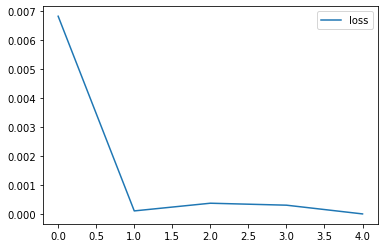

In [24]:
sRNN_loss_hist.plot()

### A.4 - Predictions from trained model

#### a) First batch
We'll start with one test batch:

In [33]:
# First test batch:
test_batch_1 = X_train_[-n_x_lags:]

In [34]:
# compute the first prediction:
y_hat_1 = sRNN_model.predict(x = test_batch_1.reshape(1,n_x_lags,n_features))
print(f"Prediction on first test batch: y_hat_1={y_hat_1}")

1/1 [==============================] - 0s 23ms/step
Prediction on first test batch: y_hat_1=[[0.9520348]]


Check first entry of the test data:

In [35]:
X_test_[0]

array([0.94955134])

#### b) Test set

Now we will use our model to predict the next 50 values and comapre them to the test data set.

In [85]:
X_train_.shape

(451, 1)

In [98]:
# Init forecast array
Y_hat = np.empty(len(X_test_))

# First forecast
Y_hat[0] = sRNN_model.predict(X_train_[-n_x_lags:].reshape(1, n_x_lags, n_features))

for i in range(1,len(X_test_)):
    
    input_values = np.concatenate([X_train_[-n_x_lags+i:,0], Y_hat[:i]],axis = 0) # Careful with the shape
    y_hat = sRNN_model.predict(input_values.reshape(1, n_x_lags, n_features))
    Y_hat[i]= y_hat
    

1/1 [==============================] - 0s 23ms/step


Note that we're forecasting using previous forecasts. As time goes by, the result deviates from the true values:

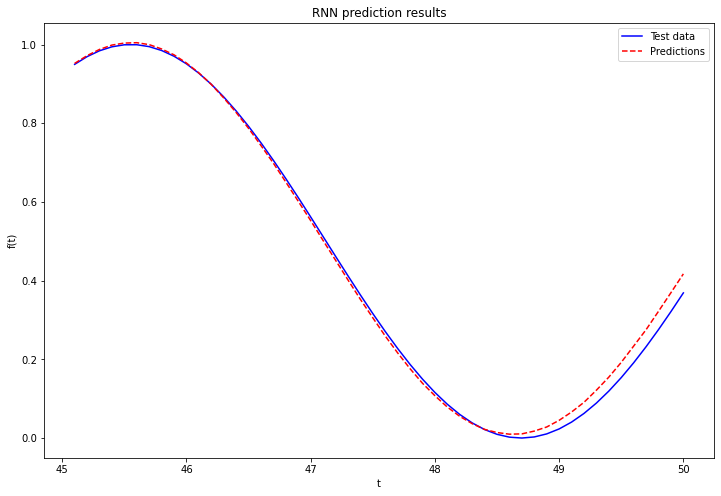

In [99]:
s = t[-n_x_lags:]
plt.figure(figsize=(12,8))
plt.plot(s,X_test_[:,0],'b', label='Test data')
plt.plot(s,Y_hat,'r--', label='Predictions')
plt.xlabel('t')
plt.ylabel('f(t)')
plt.title('RNN prediction results')
plt.legend()
plt.show()

## B - LSTM on synthetic data

See lecture 84 of the course. Will continue by adding more functionalities. Portilla doesn't really discuss GRUs though.


### B.1 - Prelims

Make the imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from datetime import datetime

In [2]:
%matplotlib inline

Data utilities imports:

In [3]:
# MinMax  scaler 
from sklearn.preprocessing import MinMaxScaler

# Batch generator for RNN
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

Neural net layers imports:

In [4]:
# Imptensorflow.keras.utilsm keras.models import Sequential

# Import dense, simple RNN and LSTM layers
from keras.layers import Dense, SimpleRNN, LSTM

# Earlystopping
from keras.callbacks import EarlyStopping

Generate the data:

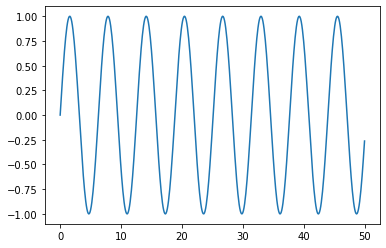

In [5]:
 # Generate synthetic data
t = np.linspace(start=0, stop=50, num=501)
X_t = np.sin(t)
plt.plot(t,X_t)

Train/Test split:

In [6]:
# DataFrame
df_X = pd.DataFrame(data =X_t, index= t , columns = ['Sine'])

# Test percentage and index
test_data_percentage = 0.1
test_data_idx = len(df_X)-int(len(df_X)*test_data_percentage)

# Train-test split
df_X_train = df_X.iloc[:test_data_idx]
df_X_test = df_X.iloc[test_data_idx:]

In [7]:
df_X_train

,Sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418
...,...
44.6,0.579164
44.7,0.657656
44.8,0.729577
44.9,0.794208


Scale the data:

In [8]:
# Inst. scaler
data_scaler = MinMaxScaler()

# Fit to training data
data_scaler.fit(df_X_train)

MinMaxScaler()

In [9]:
# Scale training and test sets
X_train_ = data_scaler.transform(df_X_train)
X_test_ = data_scaler.transform(df_X_test)

Next we make 2 data generators, one for training and one for validation. We will use then when training the neural net in B.2.2.

**Comment:** Portilla changes (length) n_x_lags to 49.

In [10]:
# Shorten the number of lags in the model:
n_x_lags = 49
y_batch_size = 1

# Training generator:
TSGen_train = TimeseriesGenerator(data = X_train_, targets= X_train_, length=n_x_lags, batch_size=y_batch_size)

# Validation generator
TSGen_test = TimeseriesGenerator(data = X_test_, targets=X_test_, length=n_x_lags, batch_size=y_batch_size)

### B.2 - LSTM

We focus on a specific type of RNN now.

#### B.2.1 - The model

In [34]:
# Build LSTM mdoel
n_features = 1
LSTM_model = keras.models.Sequential()
LSTM_model.add(LSTM(units = n_x_lags+1, input_shape = (n_x_lags, n_features)))
LSTM_model.add(Dense(units = 1))
LSTM_model.compile(optimizer = "adam", loss = "mse")

# LSTM early stopping
early_stop_LSTM = EarlyStopping(monitor = "val_loss", patience = 1)

In [35]:
LSTM_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50)                10400     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


Now train with the two generators and early stopping.

**Question:** Why are these callbacks useful.

#### B.2.2 - Training with early stopping and validation data

In [36]:

LSTM_model.fit(x = TSGen_train, epochs = 25,\
              validation_data=TSGen_test,\
              callbacks=[early_stop_LSTM])


Epoch 1/25
402/402 [==============================] - 8s 15ms/step - loss: 0.0082 - val_loss: 5.1909e-05
Epoch 2/25
402/402 [==============================] - 6s 14ms/step - loss: 2.3701e-04 - val_loss: 1.9192e-06
Epoch 3/25
402/402 [==============================] - 5s 14ms/step - loss: 1.3473e-04 - val_loss: 4.0134e-06


In [28]:
df_LSTM_hist = pd.DataFrame(LSTM_model.history.history)

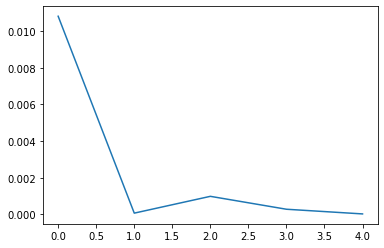

In [37]:
df_LSTM_hist["loss"].plot()

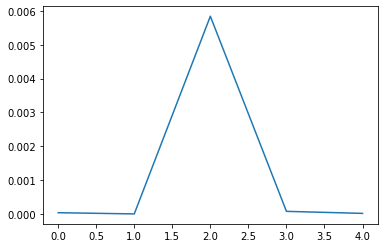

In [38]:
df_LSTM_hist["val_loss"].plot()

In [41]:
LSTM_model.save("SineData_LSTM_model_220719.h5")
# For future reference: LSTM_model = keras.models.load_model("SineData_LSTM_model_220719.h5")

**Comment:** The training of these LSTMs is very erratic. Each time I train the model above I get a different number of epochs, and it seems like I shouldn't be using early stopping for some reason. Some of the best results I got are by taking *patience* = 1 in the early stop object, and I saved that model to *SineData_LSTM_model.h5*

Let's compute our forecasts now. We have to be careful with the input data that we will feed the LSTM, as well as with our approximations to *X_test_[0]* and *X_test_[50-1]*. Below, our looping index goes from 1 to *(n_x_lags-1)*.

#### B.2.3 - Validating the model with forecasts

Here we use our trained model to predict the next 50 values of the time series, and compare the result to the testing data.

**Comments:** 
1) Portilla calls these predictions, and uses the term forecasting for completely out-of-sample inputs.
2) I've repeated this step several times to get good results. I obtained the best results with 3 epochs and a *patience* of 1, as opposed to Portilla's 6 epochs and *patience*=2 in the *early_stop*.

In [39]:
# Init forecast array
Y_hat = np.empty(shape = len(X_test_))

# Predict Y_hat[0]
Y_hat[0]= LSTM_model.predict(x = X_train_[-n_x_lags:].reshape(1, n_x_lags, n_features), batch_size = 1)

# Forecasting loop
#for i in range(1,len(Y_hat)):
for i in range(1, n_x_lags):
    
    # Make forecast input values array
    input_values = np.concatenate([X_train_[len(X_train_)-n_x_lags+i:,0], Y_hat[:i]], axis =0)
    
    # Compute forecast with LSTM
    y_hat = LSTM_model.predict(input_values.reshape(1, n_x_lags, n_features), batch_size = 1)
    
    # Add to array
    Y_hat[i]=y_hat
    
# Last entry:
Y_hat[-1] = LSTM_model.predict(Y_hat[:-1].reshape(1, n_x_lags, n_features), batch_size = 1)
    

1/1 [==============================] - 0s 22ms/step


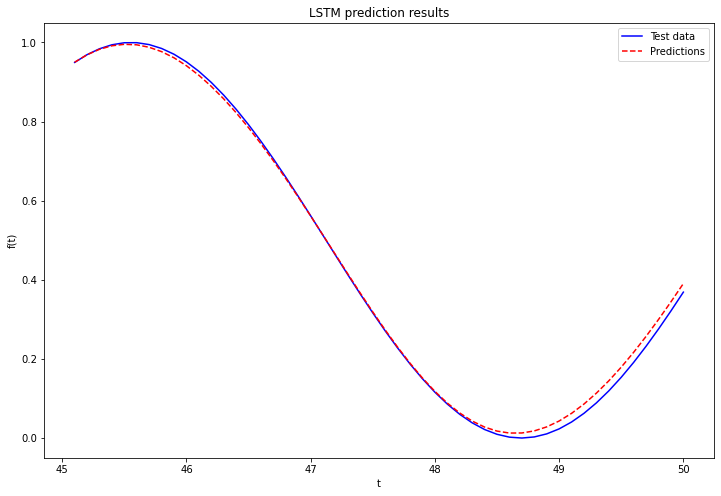

In [40]:
s = t[-len(X_test_):]
plt.figure(figsize = (12,8))
plt.plot(s,X_test_[:,0],'b', label='Test data')
plt.plot(s,Y_hat,'r--', label='Predictions')
plt.xlabel('t')
plt.ylabel('f(t)')
plt.title('LSTM prediction results')
plt.legend()
plt.show()

Finally, we plot the non rescaled data. Let's arrange everything into a dataframe.

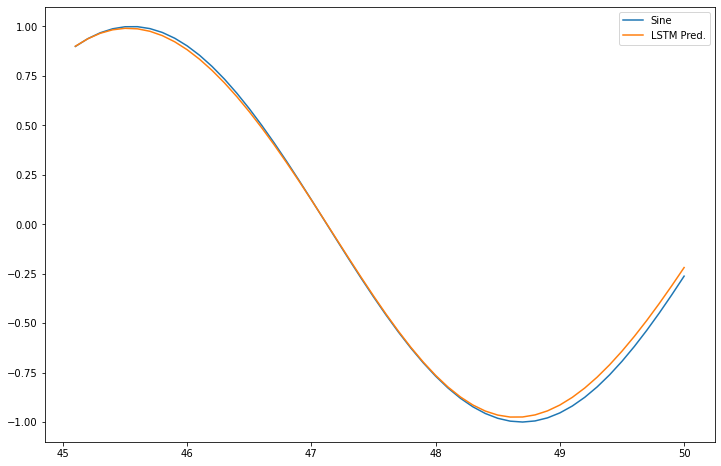

In [42]:
# Rescale predictions
X_pred = data_scaler.inverse_transform(Y_hat.reshape(-1,1))[:,0]

# Create new data frame with predictions
df_test_ = pd.DataFrame.copy(df_X_test)
df_test_['LSTM Pred.'] = X_pred

# Plot final result
df_test_.plot(figsize = (12,8))

#### B.2.4 - Out-of-sample forecasting

In Portilla's lectures, the next step is what he calls forecasting, by making out-of-sample predictions for the next 25 points. To briefly summarize what we did before:

1) We split our data (501 values) into training (451 vals) and testing (50 vals) subsets.
2) We train our model on the training data and use the testing data for validation.
3) We then use the LSTM to predict the 50 timesteps after the training data, and compared these forecasts to the test data.
4) We repeat (2) until the results in (3) are satisfying.

Now we start over from scratch:
1) We will scale our entire dataset of 501 points.
2) We will train an LSTM on the entirety of the dataset.
3) We will predict the next 25 values of our time series. This time we won't compare them to known values.

**Comment:** Shouldn't we be doing this with our previous weights?


In [46]:
# Init. and train scaler:
fdata_scaler = MinMaxScaler()
fdata_scaler.fit(df_X)

# Produce scaled dataset
X_ = fdata_scaler.transform(df_X)

In [47]:
X_.shape

(501, 1)

In [48]:
# Input/output data
n_features =1
n_x_lags =50
y_batch_size = 1

# Make the TimeseriesGenerator() for training
fTSGen = TimeseriesGenerator(data= X_, targets = X_, length = n_x_lags, batch_size=y_batch_size)

In [49]:
# Model
fLSTM_model = keras.models.Sequential(layers = [LSTM(units = 50, input_shape = (n_x_lags, n_features)),\
                                                Dense(units = 1)])
fLSTM_model.compile(optimizer="adam", loss = "mse")

In [51]:
# Training:
fLSTM_model.fit(x = fTSGen, epochs = 5)

Epoch 1/5
451/451 [==============================] - 6s 14ms/step - loss: 2.4494e-05
Epoch 2/5
451/451 [==============================] - 6s 14ms/step - loss: 9.9601e-05
Epoch 3/5
451/451 [==============================] - 6s 14ms/step - loss: 7.6486e-05
Epoch 4/5
451/451 [==============================] - 6s 14ms/step - loss: 9.1644e-05
Epoch 5/5
451/451 [==============================] - 6s 14ms/step - loss: 2.3416e-05


Now we predict the 25 values. Recall we constructed our synthetic data with:

        t = np.linspace(start=0, stop=50, num=501)
        X_t = np.sin(t)
        


In [61]:
# forecasting horizon
n_fhor = 25

# For plotting later
t_f = np.arange(start = t[-1]+0.1, stop = t[-1]+0.1*(n_fhor+1), step = 0.1)

# Predictions vector
Z_hat = np.empty(n_fhor)

In [76]:
# Compute Z_hat[0]
Z_hat[0] = fLSTM_model.predict(x = X_[-n_x_lags:].reshape(y_batch_size, n_x_lags, n_features), batch_size=y_batch_size)[0]

# 
N_X = len(X_)

for i in range(1,n_fhor):
    
    # Input data
    input_data = np.concatenate([X_[N_X-n_x_lags+i:N_X,0], Z_hat[:i]], axis = 0)
    
    # Compute prediction
    Z_hat[i]= fLSTM_model.predict(x = input_data.reshape(y_batch_size, n_x_lags, n_features), batch_size = y_batch_size)
    


1/1 [==============================] - 0s 19ms/step


In [80]:
# Rescale the forecasts
Z_hat_sc = fdata_scaler.inverse_transform(Z_hat.reshape(-1,1))[:,0]

Now we plot everything

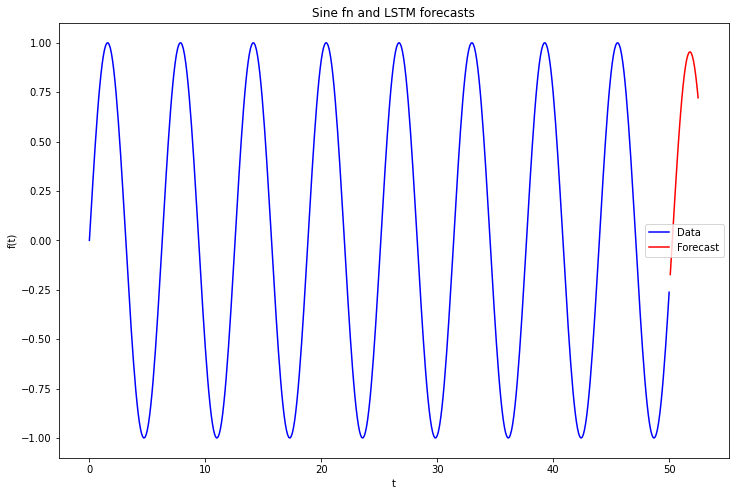

In [82]:
plt.figure(figsize = (12,8))
plt.xlabel("t")
plt.ylabel("f(t)")

plt.plot(t,X_t,'b', label='Data')
plt.plot(t_f,Z_hat_sc,'r', label='Forecast')


plt.title('Sine fn and LSTM forecasts')
plt.legend()
plt.show()

___________________________________________________________________________

#### **Appendix: Incorrect Forecast**

Here I did something that is incorrect. 

In [36]:
Y_hat = np.empty(len(X_test_))

In [55]:
X = np.concatenate([X_train_[-n_x_lags:], X_test_], axis = 0)

In [57]:
for i in range(len(Y_hat)):
    test_batch = X[i:i+n_x_lags].reshape(1, n_x_lags, n_features)
    y_hat = sRNN_model.predict(x = test_batch)
    Y_hat[i] = y_hat

1/1 [==============================] - 0s 20ms/step


The results are too good to be true here:

In [68]:
pred_error = np.sqrt(np.sum((Y_hat-X_test_[:,0])**2))
print(f"Euclidian error ||Y_hat-X_test_||={pred_error}")

Euclidian error ||Y_hat-X_test_||=0.02647001820031852


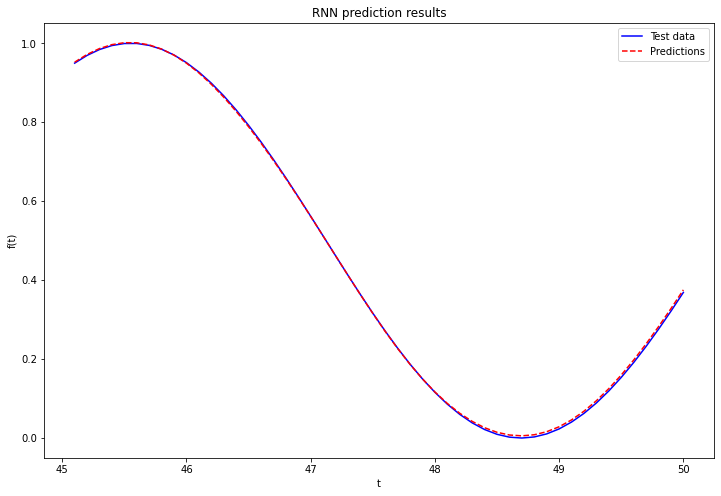

In [83]:
s = t[-n_x_lags:]
plt.plot(s,X_test_[:,0],'b', label='Test data')
plt.plot(s,Y_hat,'r--', label='Predictions')
plt.xlabel('t')
plt.ylabel('f(t)')
plt.title('RNN prediction results')
plt.legend()
plt.show()